# Project Background
This is the capstone project of **Udacity Data Scientist Nanodegree program**. The goal of this project is get hands-on experience of manipulating large datasets with Spark and learn how to use Spark MLlib to build machine learning pipeline and models.

Imagine we are working on a data team for a popular digital music service, Sparkify, which is similar to Spotify or Pandora. Every time a user interacts with the service while they are playing songs, logging out, thumb up a song, hearing an ad, it generates a log. Our job is to helping our business thrive.
 
# Problem Statement
* Goal: predict which users are at risk to churn.
* Strategy: since the full dataset is really large (12GB), we'll use Spark for ETL and use Spark ML library for building machine learning pipeline. We also use AWS EMR clusters to speed up the computation.
* Expected Result: build a "churn classifier" which can produce the probabilty of churn for each user.

# Metrics
Since this is a standard binary classification problem, we'll use Area Under Curve of ROC (AUC ROC) to measure the performance (e.g. ranking ability) of the prediction result. Both for training dataset & validation dataset for preventing over-fitting.
* AUC ROC train (by cross validation)
* AUC ROC valid (by hold-out dataset)

In [1]:
spark.sparkContext.getConf().get('spark.driver.memory')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1609336351452_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'2048M'

In [2]:
#install useful libraries
sc.install_pypi_package("pandas==1.2.0")
sc.install_pypi_package("matplotlib==3.3.3")
sc.install_pypi_package("seaborn==0.11.1")
sc.install_pypi_package("ipython==7.19.0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# import pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

#python libraries
import numpy as np
import math
import pandas as pd
from datetime import datetime

#visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#SparkML
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Read in sparkify dataset

#full dataset - 12 GB
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
#small dataset
#mini_dataset = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"

df = spark.read.json(event_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df.cache()
df.show(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|  Popol Vuh|Logged In|    Shlok|     M|          278| Johnson|524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
|Los Bunkers|Logged In|  Vianney|     F|            9|  Miller|238.39302| paid|San Francisco-Oak...|   PUT|NextSong|1537500318000|    20836|         MiÃ

In [7]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

# Data Preprocessing
We are going load and clean the dataset, checking for invalid or missing data.

### Count missing data

In [8]:
start = datetime.now()

print("Null value counts by column:")
df = df.withColumn("userId", F.col("userId").cast("int"))
df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

#print time spent
end = datetime.now()
print("running time: ",end - start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Null value counts by column:
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|5408927|   0|   778479|778479|            0|  778479|5408927|    0|  778479|     0|   0|      778479|        0|5408927|     0|  0|   778479|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

running time:  0:02:20.515327

### There are some columns that have same number of missing values
1. **artist**, **length**, **song** - these columns have same number of missing values (5408927). We can show that there are some events that are not suitable for recording those columns (ex: Downgrade or Upgrade).

2. **firstName**, **gender**, **lastName**, **location**, **registration**, **userAgent** - these columns have same number of missing values (778479), we can show that there are some events that we can't actually recognize the user (ex: Logged Out)

In [9]:
print('artist is not null: ')
df.filter('artist is not null').select('page').dropDuplicates().show(10)

missing_artist_song = df.filter((F.col('artist').isNull()) & 
                              (F.col('length').isNull()) &
                              (F.col('song').isNull()) 
                            )
print("records missing artist & song information: ")
missing_artist_song.select("page").dropDuplicates().show(30)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

artist is not null: 
+--------+
|    page|
+--------+
|NextSong|
+--------+

records missing artist & song information: 
+--------------------+
|                page|
+--------------------+
|           Downgrade|
|       Save Settings|
|               Error|
|     Add to Playlist|
|                Help|
|      Submit Upgrade|
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|         Roll Advert|
|               About|
|             Upgrade|
|Cancellation Conf...|
| Submit Registration|
|               Login|
|            Register|
|           Thumbs Up|
|              Logout|
|            Settings|
|          Add Friend|
+--------------------+

In [10]:
print("records missing user background:")
missing_user_background = df.filter((F.col('firstName').isNull()) & 
                              (F.col('gender').isNull()) &
                              (F.col('lastName').isNull()) &
                              (F.col('location').isNull()) &
                              (F.col('registration').isNull()) &
                              (F.col('userAgent').isNull()) &
                              (F.col('userId').isNull()))
missing_user_background.select("auth").dropDuplicates().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

records missing user background:
+----+
|auth|
+----+
+----+

### Data Cleaning

#### Remove records that don't have userId
Since our goal is to predict user churn, those records without userId can not help us, so we will remove them.

In [11]:
df = df.filter(~F.col("userID").isNull())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Create "state" column
Current location data is a bit too detail to analyze, we wan't to simplify it to "state" level.

In [12]:
df = df.withColumn('state', F.split(F.col('location'),', ')[1])
df.select("location","state").limit(2).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            location|state|
+--------------------+-----+
|Dallas-Fort Worth...|   TX|
|San Francisco-Oak...|   CA|
+--------------------+-----+

#### Adjust timestamp to second-based
The original timestamp is not second-based (UNIX like) but milliseconds-based (Javascript like), so we will convert thme by diveide by 1000.

In [13]:
df = df.withColumn('registration', F.col('registration')/1000)
df = df.withColumn('ts', F.col('ts')/1000)
df = df.withColumn('second_after_registration',(F.col('ts')-F.col('registration')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Exploratory Data Analysis

There are 5 steps below
1. **Define Churn** - define churn by using "Cancellation Confirmation" events for further analytics.
2. **Basic manipulations & user aggregation** - Currently we only have event-based data; however, it is not enough for our user-based analysis. So we are going to groupby those events into user-based feature to distingush the difference between churn & not churn user.
3. **Sample a Small Subset of Data and Covert into Pandas Dataframe** - Since we wan't to use seaborn & matplotlib's strong visualization ability, we have to prepare and feed them into smaller pandas dataframe (not spark dataframe).
4. **Data Exploration** - We can quickly calcuated some statistics before really dig into visualizations and the numbers.
5. **Visualization & analysis** - we will create visualizations for analyzing lots of feature in a scalable manner, both numerical and categorical featuers.

## 1. Define Churn
We will define churn by using "Cancellation Confirmation" log, since this is the most easy and straightforward definition to use.

In [14]:
#create a new flag "Churn"
df = df.withColumn("Churn", F.when(F.col('page')=='Cancellation Confirmation', 1).otherwise(0))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Basic manipulations & user aggregation

In [15]:
#create a new flat "lastest_record_is_pay" for future analysis 
w  = Window.partitionBy(F.col("userId")).orderBy(F.col("ts").desc())
df = df.withColumn('max_ts_by_user',F.max('ts').over(w))
df = df.withColumn('lastest_record_is_paid', 
                   F.when((F.col('max_ts_by_user')==F.col('ts')) & (F.col('level')=='paid'),1).otherwise(0))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
#create "date" feature for further analysis
df = df.withColumn('registration_date', F.to_date(F.from_unixtime(F.col('registration'))))
df = df.withColumn('last_interaction_date', F.to_date(F.from_unixtime(F.col('max_ts_by_user'))))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
#show result
df.cache()
df.dropDuplicates(subset=['userId']).select('userId','registration_date','last_interaction_date','lastest_record_is_paid').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+---------------------+----------------------+
| userId|registration_date|last_interaction_date|lastest_record_is_paid|
+-------+-----------------+---------------------+----------------------+
|1001129|       2018-08-25|           2018-11-23|                     0|
|1011733|       2018-08-03|           2018-10-18|                     1|
|1016354|       2018-07-28|           2018-11-10|                     0|
|1016416|       2018-09-05|           2018-11-25|                     0|
|1034317|       2018-07-29|           2018-11-12|                     0|
+-------+-----------------+---------------------+----------------------+
only showing top 5 rows

### Aggregation by user

In [18]:
#feature aggregation
df_agg = df.groupby('userId').agg(
    F.count('auth').alias('record_count'),
    F.approxCountDistinct(F.col('artist')).alias('distinct_artist_count'),
    F.first('gender').alias('gender'),
    F.mean('itemInSession').alias('itemInSession_mean'),
    F.mean('length').alias('length_mean'),
    F.count(F.when(F.col('level')=='paid',1)).alias('paid_record_count'),
    F.count(F.when(F.col('level')=='free',1)).alias('free_record_count'),
    
    #page event
    F.count(F.when(F.col('page')=='NextSong',1)).alias('NextSong_count'),
    F.count(F.when(F.col('page')=='Thumbs Up',1)).alias('Thumbs_Up_count'),
    F.count(F.when(F.col('page')=='Thumbs Down',1)).alias('Thumbs_Down_count'),
    F.count(F.when(F.col('page')=='Downgrade',1)).alias('Downgrade_count'),
    F.count(F.when(F.col('page')=='Upgrade',1)).alias('Upgrade_count'),
    F.count(F.when(F.col('page')=='Roll Advert',1)).alias('Roll_Advert_count'),
    F.count(F.when(F.col('page')=='Add to Playlist',1)).alias('Add_to_Playlist_count'),
    F.count(F.when(F.col('page')=='Settings',1)).alias('Settings_count'),
    F.count(F.when(F.col('page')=='Help',1)).alias('Help_count'),
    F.count(F.when(F.col('page')=='Error',1)).alias('Error_count'),
    
    #time aggregation
    F.first(F.col("registration")).alias('registration_ts'),
    F.first(F.col("max_ts_by_user")).alias('last_interaction_ts'),
    F.min(F.col('ts')).alias('first_record_ts'),
    F.mean(F.col('ts')).alias('mean_record_ts'),
    
    F.first(F.col("registration_date")).alias('registration_date'),
    F.first(F.col("last_interaction_date")).alias('last_interaction_date'),
    F.max(F.col('second_after_registration')).alias('since_registration_ts'), 
    F.max(F.col('lastest_record_is_paid')).alias("is_paid_user"),

    #other
    F.approxCountDistinct(F.col('sessionId')).alias('sessionId_count'),
    F.first(F.col('state')).alias('state'),
    F.max(F.col('Churn')).alias('is_churn')
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df_agg = df_agg.fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3. Sample a Small Subset of Data and Covert into Pandas Dataframe
We wil sample only 5% of data to do visulization to prevent head node out of memory (since we retrive the distributed data back to our head node)

In [20]:
df_agg.cache()
sample_subset = df_agg.sample(False, 0.05, 41)
pdf = sample_subset.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
pd.set_option('display.max_columns', None)
print('userID_aggretation_result: ')
pdf.head(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

userID_aggretation_result: 
    userId  record_count  distinct_artist_count gender  itemInSession_mean  \
0  1041322          1699                   1115      M          109.959388   
1  1288643           228                    176      F           16.122807   
2  1588738          2382                   1319      F          263.772880   
3  1692735          1532                    997      F           85.667102   
4  1866569           488                    357      M           47.108607   

   length_mean  paid_record_count  free_record_count  NextSong_count  \
0   247.697881               1450                249            1407   
1   241.499340                  0                228             186   
2   252.222492               2382                  0            2014   
3   248.912811               1114                418            1273   
4   254.126114                431                 57             375   

   Thumbs_Up_count  Thumbs_Down_count  Downgrade_count  Upgrade_count 

## 4. Data Exploration
We can quickly calcuated some statistics before really dig into the numbers.
* We can see there is a huge difference in the distribution in terms of product engagement.
* It would be more clear when we use visualization.

In [22]:
pdf.groupby('is_churn').describe()[['Add_to_Playlist_count','NextSong_count','Thumbs_Up_count']]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         Add_to_Playlist_count                                              \
                         count       mean        std  min  25%   50%   75%   
is_churn                                                                     
0                        852.0  28.586854  32.902923  0.0  6.0  17.0  41.0   
1                        238.0  24.130252  31.043930  0.0  5.0  12.5  31.0   

                NextSong_count                                                \
            max          count         mean          std  min     25%    50%   
is_churn                                                                       
0         202.0          852.0  1008.494131  1160.720377  1.0  218.00  602.0   
1         191.0          238.0   847.857143  1049.624195  4.0  184.25  452.0   

                          Thumbs_Up_count                                    \
              75%     max           count       mean        std  min    25%   
is_churn                                          

## 5. Data Visualization
We will seperate users into 2 groups (churn, not churn), and build visualizations to further discover the difference of distribution of the data. We will do it in a scalable manner -  if we create more useful feature in the future, we can still using the same code to provide visualization, for both numerical and categorical featuers.

In [23]:
#select numeric columns
numeric_columns = list(pdf.select_dtypes(include=['int32','int64','float64']).columns)
numeric_columns = [col_name for col_name in numeric_columns if col_name not in ['userId','is_churn']]
print(numeric_columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['record_count', 'distinct_artist_count', 'itemInSession_mean', 'length_mean', 'paid_record_count', 'free_record_count', 'NextSong_count', 'Thumbs_Up_count', 'Thumbs_Down_count', 'Downgrade_count', 'Upgrade_count', 'Roll_Advert_count', 'Add_to_Playlist_count', 'Settings_count', 'Help_count', 'Error_count', 'registration_ts', 'last_interaction_ts', 'first_record_ts', 'mean_record_ts', 'since_registration_ts', 'is_paid_user', 'sessionId_count']

### Plot numeric features distribution by KDE plot
Kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, similar to a histogram. KDE aims to approximate the underlying probability density function by producing a continuous density estimate.

* For each graph, if the blue & orange line separate to each other, we know that it might be a good feature / predictor for distinguishing churn and not-churn user.

In [24]:
#remove outlier for better visualization
def remove_numeric_outlier(df):
    analysis_data = df.copy()
    for column in list(analysis_data.select_dtypes(include='float64').columns):
        current_column = analysis_data[column]
        
        #set upper bound & lower bound
        lower_bound = current_column.quantile(.05)
        upper_bound = current_column.quantile(.95)
        analysis_data = analysis_data[(analysis_data[column] < upper_bound) &  (analysis_data[column] > lower_bound)]
    return analysis_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

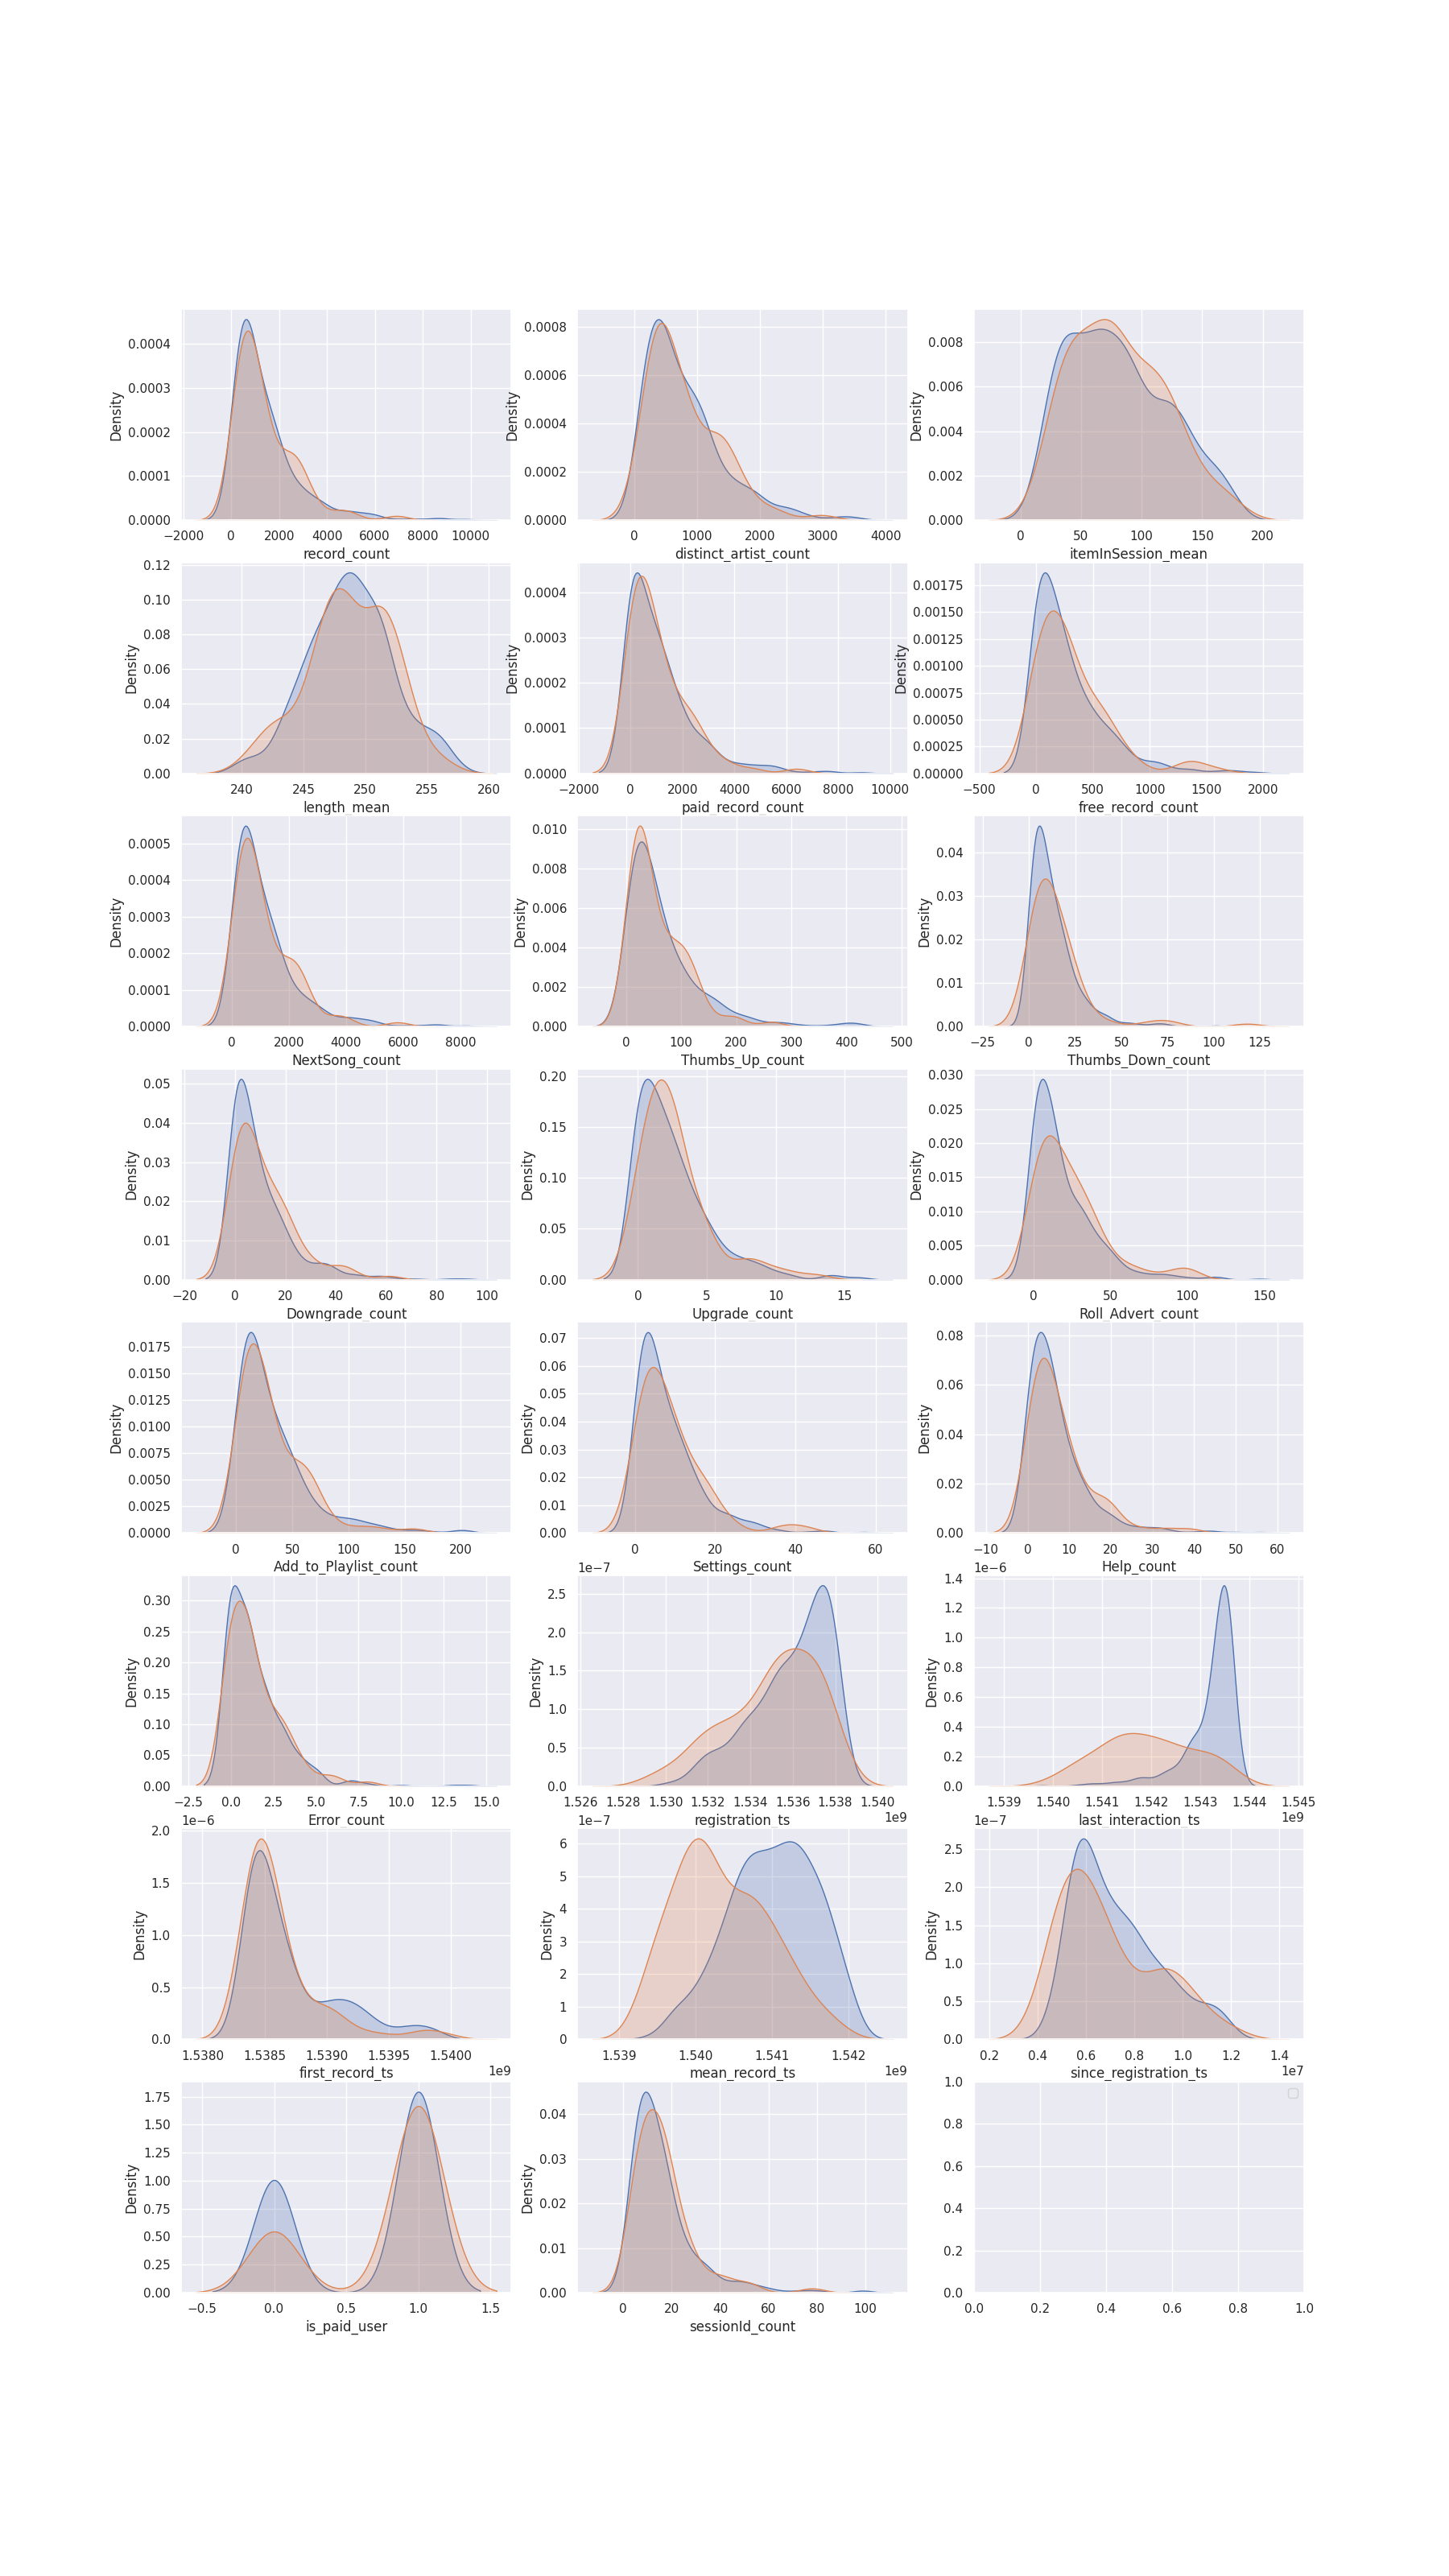

In [63]:
#decide how much row to plot
plot_rows = math.ceil(len(numeric_columns)/3)
analysis_data = remove_numeric_outlier(pdf)

#plot numeric data columns at scale
fig_kde, axis_kde = plt.subplots(plot_rows,3, figsize=(18, 4*plot_rows)) #,squeeze=False
for attr_index in range(len(numeric_columns)):
    attr = numeric_columns[attr_index]
    
    #set plot index
    index_0, index_1 = math.floor(attr_index/3), attr_index%3;
    #axis_kde[index_0][index_1].set_title(attr)

    #plot data
    for churn_flag in [0,1]:
        label = 'Churn' if (churn_flag == 1) else 'No Churn'
        sns.kdeplot(analysis_data[attr][analysis_data.is_churn==churn_flag], label=label, ax=axis_kde[index_0][index_1],shade=True);
        plt.legend();
del analysis_data
%matplot plt

### Plot time-related featuers by line graph
We want to use line graph to visualize the trend and distribution of time-related features.
* For each graph, if the blue & orange line separate to each other, we know that it might be a good feature / predictor for distinguishing churn and not-churn user.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

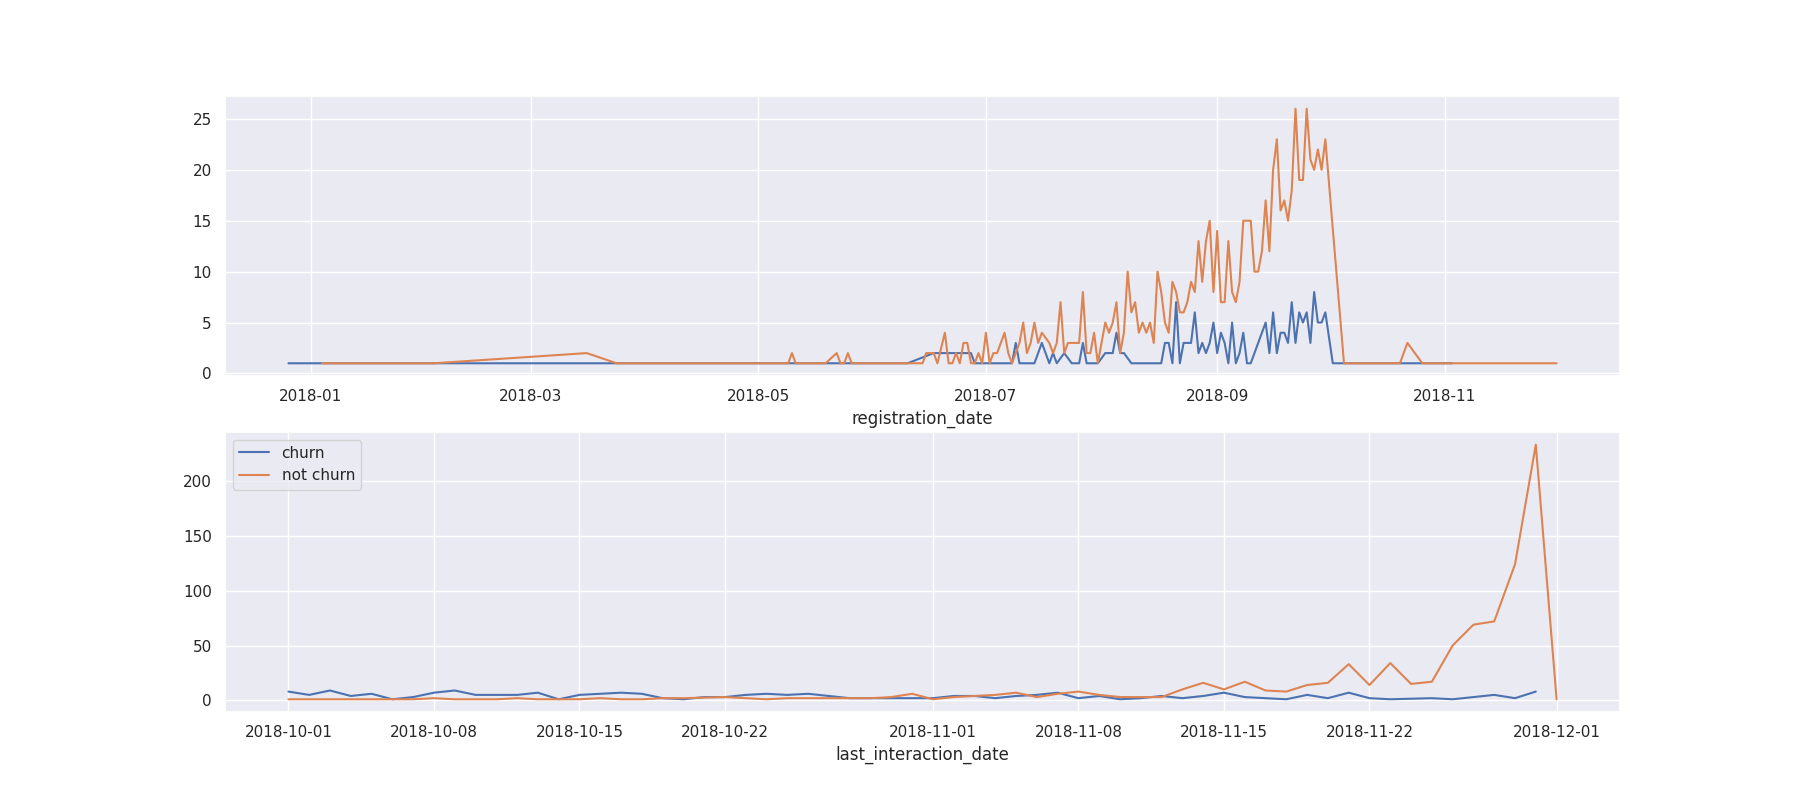

In [26]:
#select date related columns
date_columns = [col for col in pdf.columns if 'date' in col]

#decide how much row to plot
plot_rows = math.ceil(len(date_columns))

#plot numeric data columns at scale
fig_date, axis_date = plt.subplots(plot_rows, 1, figsize=(18, 4*plot_rows),squeeze=False)

for index in range(len(date_columns)):
    attr = date_columns[index]
    
    #set plot index
    index_0, index_1 = math.floor(index/1), index%1

    #plot data
    pdf[pdf.is_churn==1].groupby([attr]).count()['userId'].plot(kind="line",label="churn", ax=axis_date[index_0,index_1])
    pdf[pdf.is_churn==0].groupby([attr]).count()['userId'].plot(kind="line",label="not churn", ax=axis_date[index_0,index_1])
    plt.legend();
%matplot plt

### Plot categorical featuers by stacked bar chart
We want to use stacked bar chart graph to visualize the proportion and distribution of categorical features.

In [27]:
#generate categorical columns
categorical_columns = list(pdf.select_dtypes(include='object').columns)
categorical_columns = [col for col in categorical_columns if 'date' not in col]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

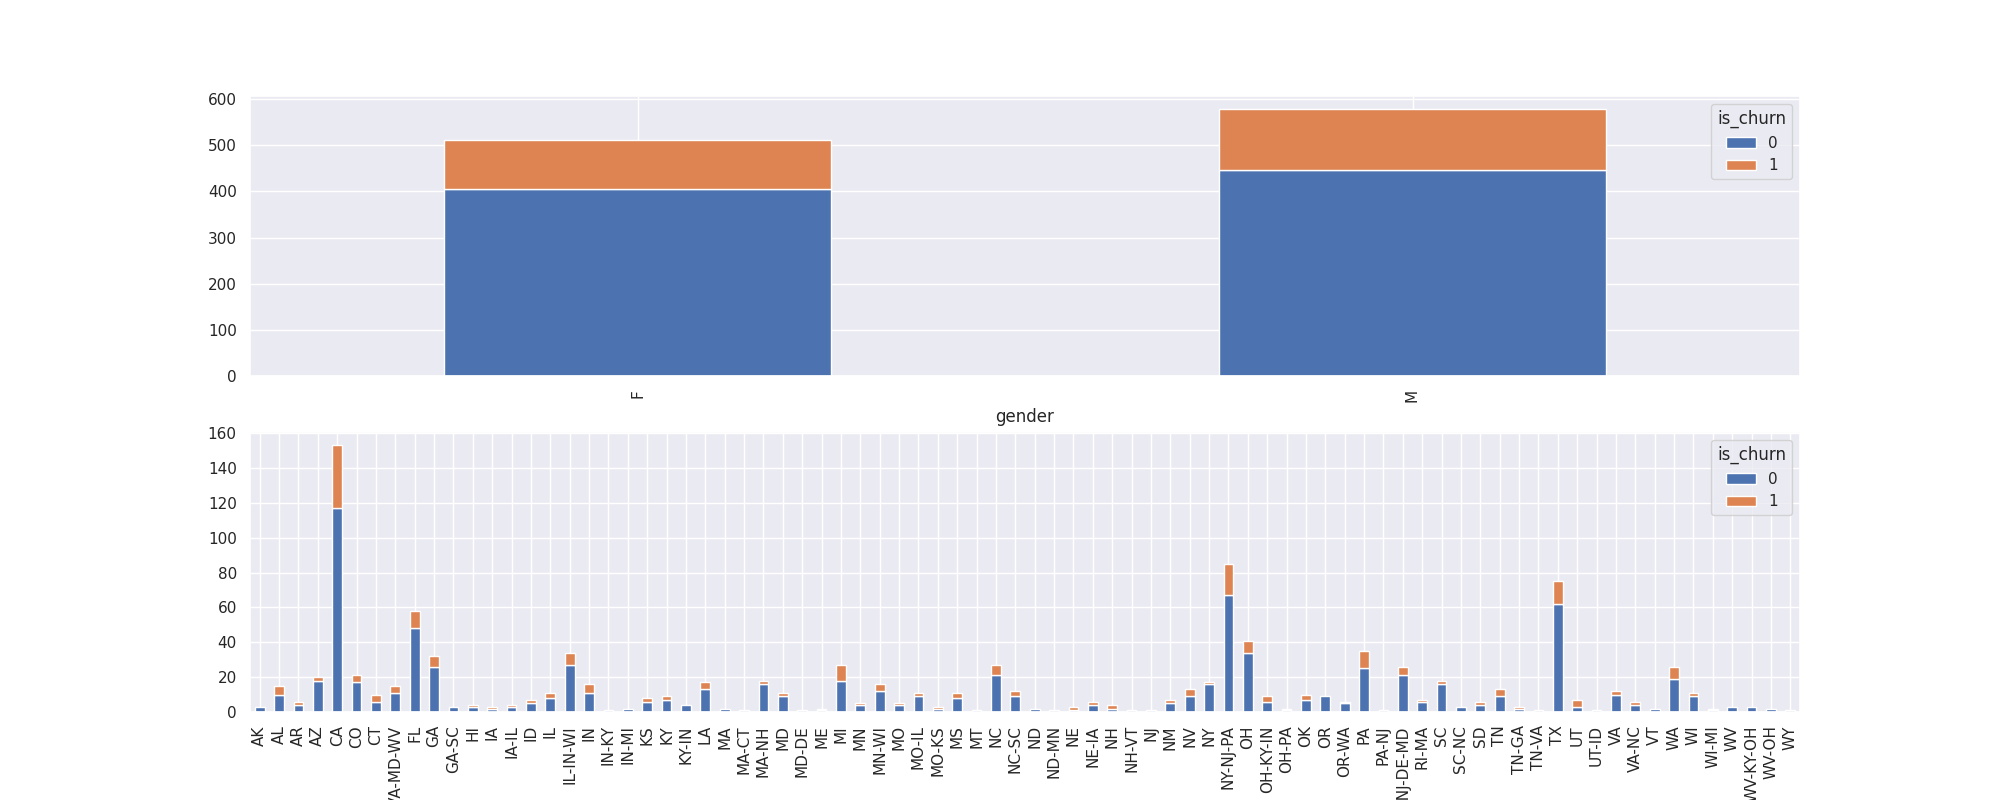

In [28]:
#decide how much row to plot
plot_rows = math.ceil(len(categorical_columns))

#basic setup
fig, axis = plt.subplots(plot_rows,1,figsize=(20,4*plot_rows),squeeze=False)

#plot categorical data columns at scale
index = 0
for col in categorical_columns:
    index_0, index_1 = math.floor(index/1), index%1    
    data = pdf.copy()[[col,'is_churn']]
    
    #plot stacked bar
    df_plot = data.groupby([col, 'is_churn']).size().reset_index().pivot(columns='is_churn', index=col, values=0)
    df_plot.plot(kind='bar', stacked=True, ax=axis[index_0,index_1])
    index = index+1
    
%matplot plt

# Modeling & Refinement

we are going to implement the core process of modeling. There are 5 steps below.

1. **Extract Features** - pick features which would be useful to put into modeling.
2. **Split Data into Rest & Validation** - split data into 'validation' and 'rest', and use 'rest' to evaluate performance. At the end we will use 'validation' to validate unseen data performance.
3. **Build Pipeline & Try Different Models** - we will test out our data pipeline and use several models to try it out.
4. **Measure Baseline Performance** - measure initial performance of our model to set up a baseline.
5. **Refinement: Tuning Hyper-parameter by Grid Search** - use grid search to fine-tune our final model.

## 1. Extract Features

In [29]:
modeling_columns = [
    #user profile
    'gender','is_paid_user','state',
    
    #engagement metrics
    'record_count','distinct_artist_count','sessionId_count','itemInSession_mean','length_mean','paid_record_count','free_record_count',
    
    #page event
    'NextSong_count','Thumbs_Up_count','Thumbs_Down_count','Downgrade_count','Upgrade_count','Roll_Advert_count','Add_to_Playlist_count','Settings_count','Settings_count','Help_count','Error_count',
    
    #time
    'registration_ts','last_interaction_ts','first_record_ts','mean_record_ts','since_registration_ts',
    
    #label
    'is_churn'
]
df_modeling = df_agg.select(modeling_columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
df_modeling = df_modeling.withColumnRenamed('is_churn','label')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Split Data into Rest & Validation

In [31]:
rest, validation = df_modeling.randomSplit([0.7, 0.3], seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3. Build Pipeline & Try Different Models
Here is what we gonna do,

1. randomly sample data to test out our pipeline before any expensive training.
2. evaluate the performance of a bunch of baseline models.

In [32]:
#set up baseline models
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbt = GBTClassifier()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
#evaluate model
def main_pipeline(model, data):
    #create feature column
    feature_columns = [ col for col in modeling_columns if col not in ['is_churn','gender','state']] 
    
    #assemble features into vector
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    #set up pipeline
    pipeline = Pipeline(stages=[assembler, model])

    #set up cross validation
    inital_paramGrid = ParamGridBuilder().build()
    crossval = CrossValidator(estimator = pipeline,
                          estimatorParamMaps = inital_paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 3)
    
    #fit model
    cvModel = crossval.fit(data)

    return cvModel.avgMetrics, cvModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Quickly test out our pipeline before expensive training.

In [34]:
sample_data = rest.sample(False, 0.1, 41)
sample_data.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[gender: string, is_paid_user: int, state: string, record_count: bigint, distinct_artist_count: bigint, sessionId_count: bigint, itemInSession_mean: double, length_mean: double, paid_record_count: bigint, free_record_count: bigint, NextSong_count: bigint, Thumbs_Up_count: bigint, Thumbs_Down_count: bigint, Downgrade_count: bigint, Upgrade_count: bigint, Roll_Advert_count: bigint, Add_to_Playlist_count: bigint, Settings_count: bigint, Settings_count: bigint, Help_count: bigint, Error_count: bigint, registration_ts: double, last_interaction_ts: double, first_record_ts: double, mean_record_ts: double, since_registration_ts: double, label: int]

### Test out different kind of model before dig into hyper-parameter tunning

In [45]:
def test_model(model, data):
    print('fitting: ', model)
    start = datetime.now()
    result, cvModel = main_pipeline(model, data)
    end = datetime.now()
    print(model, result, ", time: ",end - start)
    return result, cvModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
gbt_trained = test_model(gbt, sample_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

fitting:  GBTClassifier_531c84a48d78
GBTClassifier_531c84a48d78 [0.9188222857455122] , time:  0:02:30.699356
CrossValidatorModel_50e1de3ce7bc

Exception in thread cell_monitor-36:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1081



In [47]:
score, lr_trained = test_model(lr, sample_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-47:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 2896



fitting:  LogisticRegression_17e5f9f24d23
LogisticRegression_17e5f9f24d23 [0.8740168378592112] , time:  0:01:36.240570

In [46]:
score, rfc_trained = test_model(rfc, sample_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-46:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 2693



fitting:  RandomForestClassifier_1938beb2967e
RandomForestClassifier_1938beb2967e [0.9249748330315241] , time:  0:00:15.884421

In [48]:
sample_data.unpersist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[gender: string, is_paid_user: int, state: string, record_count: bigint, distinct_artist_count: bigint, sessionId_count: bigint, itemInSession_mean: double, length_mean: double, paid_record_count: bigint, free_record_count: bigint, NextSong_count: bigint, Thumbs_Up_count: bigint, Thumbs_Down_count: bigint, Downgrade_count: bigint, Upgrade_count: bigint, Roll_Advert_count: bigint, Add_to_Playlist_count: bigint, Settings_count: bigint, Settings_count: bigint, Help_count: bigint, Error_count: bigint, registration_ts: double, last_interaction_ts: double, first_record_ts: double, mean_record_ts: double, since_registration_ts: double, label: int]

## 4. Measure Baseline Performance

### Baseline Result:
* We will feed all of our "rest" dataset into model to get baseline result
* Baseline ROC AUC performance are as follow

In [49]:
rf_baseline = RandomForestClassifier()
test_model(rf_baseline, rest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-49:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3895



fitting:  RandomForestClassifier_c333f2612642
RandomForestClassifier_c333f2612642 [0.9239927898810809] , time:  0:00:19.661648
([0.9239927898810809], CrossValidatorModel_9ecd8d6796dc)

## 5. Refinement: Tuning Hyper-parameter by Grid Search

There are lots of parameter we can tune for Random Forest Classifier. Generally, the most important features are  **maxDepth** and **numTrees**, which control the complexity of the model.
* **numTrees** - the number of trees we want to build before taking the maximum voting
* **maxDepth** - longest path between the root node and the leaf node

We will build up the best model by using **Grid Search + Cross Validation** provided from Spark.

In [54]:
#model to be tuned
rf = RandomForestClassifier()

#tunning parameters
numTrees_para = [30, 40]
maxDepth_para = [6, 8]

#set up pipeline
feature_columns = [ col for col in modeling_columns if col not in ['is_churn','gender','state']] 
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
pipeline = Pipeline(stages=[assembler, rf])

#set up parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,numTrees_para)\
    .addGrid(rf.maxDepth,maxDepth_para)\
    .build()

#set up cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
print('Running Grid Search + Cross Validation, may take some time....')
start = datetime.now()
cvModel = crossval.fit(rest)
end = datetime.now()
print("running time: ",end - start)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-55:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3996



Running Grid Search + Cross Validation, may take some time....
running time:  0:02:28.025959

### Cross-Validation Result:

In [56]:
print('Grid Search AUC ROC')
cvModel.avgMetrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Grid Search AUC ROC
[0.93025461914182, 0.9338477173148003, 0.9296198204240784, 0.9347913555901393]

In [58]:
print('best model:')
cvModel.bestModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

best model:
PipelineModel_38df06f82f33

# Model Evaluation and Validation
We want to test out our model by **unseen holdout dataset (validation)** to evalute model's final qualities.

In [59]:
#produce prediction
results = cvModel.transform(validation)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
#create evaluation dataset
eval_dataset = results.select('rawPrediction','label')
eval_dataset.show(5, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------------+-----+
|rawPrediction                          |label|
+---------------------------------------+-----+
|[38.57205612669239,1.4279438733076157] |0    |
|[16.534447480944895,23.465552519055098]|0    |
|[25.142462770135975,14.857537229864018]|0    |
|[8.56785857260095,31.43214142739905]   |1    |
|[38.02295358813877,1.9770464118612374] |0    |
+---------------------------------------+-----+
only showing top 5 rows

### Evaluation (AUC ROC) of Best Model

In [62]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(eval_dataset)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9350692812447464